In [181]:
from Config import Config
import pandas as pd
import numpy as np
import os

In [182]:
f_name = "cleaned_msg_Aug_Mar.csv"
f_path = os.path.join(Config.proccessed_data_dir, Config.chat_data_subsets_subdir, f_name)

In [183]:
df = pd.read_csv(f_path)

/var/folders/ht/m3lhbch97rbfp8h0sn087g240000gn/T/ipykernel_23202/3301406415.py:1: DtypeWarning:

Columns (5,20,24,25,26,27,28,29,30) have mixed types. Specify dtype option on import or set low_memory=False.



In [184]:
df.date = pd.to_datetime(df.date)

In [185]:
df.date.min()

Timestamp('2020-08-14 21:00:04+0000', tz='UTC')

In [186]:
messages = df[df.reply_to_msg_id.isna()==True].reset_index(drop=True)

In [187]:
cols = ["id","message", "reply_to_msg_id", "chat_name", "is_reply"]
replies = df.loc[df.reply_to_msg_id.isna()==False, cols].reset_index(drop=True)
replies["reply_to_msg_id"] = replies["reply_to_msg_id"].astype(int).astype(str) # convert to string
replies["unique_reply_to_msg_id"] = replies.chat_name + "_" + replies.reply_to_msg_id # create unique reply ids 
replies.head()

,id,message,reply_to_msg_id,chat_name,is_reply,unique_reply_to_msg_id
0,387282,Непонятно. Что с парнем?,386972,strana_chat,True,strana_chat_386972
1,387281,🌹🌹🌹❤️,387244,strana_chat,True,strana_chat_387244
2,387280,✊,387113,strana_chat,True,strana_chat_387113
3,387278,"По ссылке переходите в их сторис, там голосование",387172,strana_chat,True,strana_chat_387172
4,387277,Спасибо ❤,387113,strana_chat,True,strana_chat_387113


In [193]:
# make threads 
reply_threads = (
    replies
    .groupby('unique_reply_to_msg_id')['message']
    .agg('\n'.join)
    .reset_index(name="all_replies",drop=False)
)

In [195]:
replies.shape

(1002611, 6)

In [198]:
reply_threads.all_replies.str.len().describe()

count    627171.000000
mean        133.203616
std         369.078772
min           1.000000
25%          28.000000
50%          66.000000
75%         143.000000
max       43491.000000
Name: all_replies, dtype: float64

In [200]:
reply_threads.shape

(627171, 2)

In [192]:
messages.shape

(668573, 36)

In [196]:
df.shape

(1671184, 36)

In [199]:
# merge threads with messages
threads = (
    messages
    .merge(reply_threads, how="left", left_on="unique_msg_id", right_on="unique_reply_to_msg_id"))


In [201]:
cols = ["unique_msg_id","message", "all_replies"]
threads = threads.loc[:,cols]

In [218]:
threads["threads"] = threads[["message", "all_replies"]].fillna('').sum(axis=1)

In [221]:
threads["threads"].str.len().describe()

count    668573.000000
mean        210.864278
std         498.225754
min           1.000000
25%          32.000000
50%          76.000000
75%         193.000000
max       43779.000000
Name: threads, dtype: float64

In [222]:
threads.head()

,unique_msg_id,message,all_replies,threads
0,strana_chat_387270,✌️✌️✌️✌️✌️живе Беларусь,NaN,✌️✌️✌️✌️✌️живе Беларусь
1,strana_chat_387265,На следующей неделе - будет оооочччччэнь интре...,NaN,На следующей неделе - будет оооочччччэнь интре...
2,strana_chat_387264,Когда же Лукашенко расскажет много интересного...,NaN,Когда же Лукашенко расскажет много интересного...
3,strana_chat_387262,https://youtu.be/A2vAXc1wvbk,NaN,https://youtu.be/A2vAXc1wvbk
4,strana_chat_387244,❗️Светлана Тихановская – о главном достижении ...,"🌹🌹🌹❤️\nСветлана,все порядочные люди Республики...",❗️Светлана Тихановская – о главном достижении ...


In [248]:
import time
import multiprocessing as mp
from data_utils import clean_text, stem_text
# clean text 
# parallelize the cleaning
p = mp.Pool(mp.cpu_count()-1) # Data parallelism Object
start_time  = time.time()
threads["clean_thread"] = p.map(clean_text, threads["threads"]) 
print(time.time() - start_time)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagopal/nltk_data...
[nltk_data]   Packa

36.78616237640381


In [250]:
threads["thread_len"] = threads["clean_thread"].str.len()


In [251]:
threads_clean = threads.loc[threads["thread_len"]>0]

In [252]:
threads_clean.shape

(631479, 7)

In [254]:
threads_clean["thread_len"].describe()

count    631479.000000
mean        171.125646
std         397.653110
min           1.000000
25%          26.000000
50%          62.000000
75%         154.000000
max       31364.000000
Name: thread_len, dtype: float64

<AxesSubplot:ylabel='Frequency'>

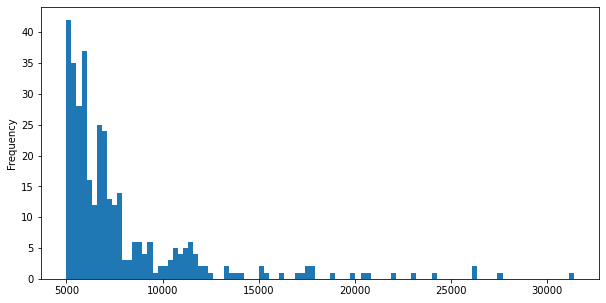

In [267]:
threads_clean.loc[threads_clean["thread_len"]>500, "thread_len"].plot(kind="hist", bins=100, figsize=(10,5))

In [258]:
xx = threads_clean[threads_clean.thread_len == 245]

In [260]:
xx.clean_thread.duplicated().sum()

2986

In [231]:
xx = threads[threads["thread_len"]>27]

In [235]:
xx.thread_len.min()

28

In [236]:
sort = xx.sort_values(by="thread_len", ascending=True)

In [237]:
sort.head(100)

,unique_msg_id,message,all_replies,threads,thread_len
399565,Gomel_strana_54906,https://youtu.be/w7GNQ2ZUu7k,NaN,https://youtu.be/w7GNQ2ZUu7k,28
43950,strana_chat_197318,https://youtu.be/z3t12Wcfy0o,NaN,https://youtu.be/z3t12Wcfy0o,28
13899,strana_chat_307845,https://youtu.be/SPRrpYHmF_E,NaN,https://youtu.be/SPRrpYHmF_E,28
621153,Novogrudok_chat_2247,"Ой, не писюха, конечно нет 😁",NaN,"Ой, не писюха, конечно нет 😁",28
13903,strana_chat_307824,https://youtu.be/kQvKA2FAtwc,NaN,https://youtu.be/kQvKA2FAtwc,28
221629,brest97pro_174778,Н531Хорошоющ890.ир7ор5678тш8,NaN,Н531Хорошоющ890.ир7ор5678тш8,28
43922,strana_chat_197372,https://youtu.be/z3t12Wcfy0o,NaN,https://youtu.be/z3t12Wcfy0o,28
221558,brest97pro_175248,Я ВАМ ЗАПРЕЩАЮ ТАК ДЕЛАТЬ,😂😂😂,Я ВАМ ЗАПРЕЩАЮ ТАК ДЕЛАТЬ😂😂😂,28
129437,pinskstrana_108133,https://youtu.be/A_ix_5NgjAs,NaN,https://youtu.be/A_ix_5NgjAs,28
621149,Novogrudok_chat_2260,Хохлы в новогрудском чате ?),NaN,Хохлы в новогрудском чате ?),28


In [223]:
# number of replies per message
replies_per_message = (replies
.groupby("unique_reply_to_msg_id")["message"]
.count()
.reset_index(name="num_replies"))

In [268]:
num_prisoners_t = regression(days_till_sunday, volume_online, protests_on_ground)

NameError: name 'regression' is not defined